In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
import keras
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Input,Activation, concatenate, Embedding, Reshape
from keras.layers import Flatten, merge, Lambda, Dropout, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.models import model_from_json
from keras.models import load_model
from keras.regularizers import l1,l2
import tensorflow as tf
import gc

In [4]:
#df = pd.read_csv('/Users/BharathiSrinivasan/Documents/GitHub/Thesis/data_final.csv', index_col=[0])
#df = pd.read_csv('/Users/BharathiSrinivasan/Documents/GitHub/Thesis/merged_data.csv')
folder = 'C:\\Users\\Pascal\\Documents\\GitHub\\instacart-market-basket-analysis\\'

df_big = pd.read_csv(folder + 'merged_data.csv')

In [5]:
#Sample orders of n customer
def data_nusers(df, n):
    unique_users = df.user_id.unique()
    i = 0
    df_nusers = pd.DataFrame()  
    for user in unique_users:
        df_nusers = df_nusers.append(df[df.user_id == user])
        i +=1
        if (i == n):
            break
    return pd.DataFrame(df_nusers)

In [67]:
# Use same data as those for which embeddings are trained
df_use = data_nusers(df_big,100)

In [68]:
#Investigating NAs
print(df_use.isnull().sum().sum())

0


In [69]:
df_use.shape

(33257, 13)

In [70]:
# Number of product IDs available
N_products = df_use['product_id'].nunique()
N_shoppers = df_use['user_id'].nunique()

In [71]:
# load embeddings model
json_file = open('NN_embed_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("NN_embed_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [72]:
def val2idx(df, cols):
    """
    Helper to index values of embedding columns
    """
    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()

    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x]+1)

    unique_vals = dict()
    for c in cols:
        unique_vals[c] = df[c].nunique()

    return df, unique_vals

In [73]:
EMBEDDING_COLUMNS = ["user_id", "product_id"]
df_deep, values = val2idx(df_use, EMBEDDING_COLUMNS)

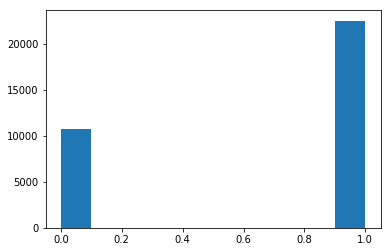

In [74]:
plt.figure()
plt.hist(df_deep.reordered)
plt.show()

In [75]:
#df_small = df.sample(frac = 0.8)

In [76]:
df_deep.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department
0,2,1,1,1,1,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs
1,2,2,2,1,1,3,5,9,8.0,Michigan Organic Kale,83,4,produce
2,2,3,3,0,1,3,5,9,8.0,Garlic Powder,104,13,pantry
3,2,4,4,1,1,3,5,9,8.0,Coconut Butter,19,13,pantry
4,2,5,5,0,1,3,5,9,8.0,Natural Sweetener,17,13,pantry


In [77]:
df_deep.drop(['product_name','department'], axis=1, inplace=True)

In [78]:
CATEGORICAL_COLUMNS = ["order_dow", "order_hour_of_day","aisle_id","department_id"]
CONTINUOUS_COLUMNS = ["days_since_prior_order","order_number","add_to_cart_order"]

In [79]:
#import seaborn as sns
#sns.heatmap(df_small.corr(),cmap="YlGnBu")

In [80]:
#One-hot encoding categorical columns
df_small = pd.get_dummies(df_use, columns=[x for x in CATEGORICAL_COLUMNS])

In [81]:
#Normalising the feature columns
df_small[CONTINUOUS_COLUMNS] = MinMaxScaler().fit_transform(df_small[CONTINUOUS_COLUMNS].values)

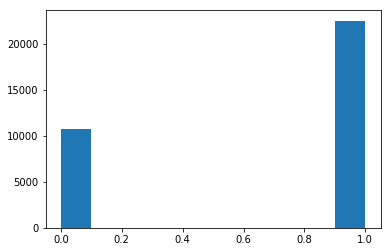

In [82]:
plt.figure()
plt.hist(df_small.reordered)
plt.show()

In [16]:
#Prepare embedding layer as separate input to Keras
#embed_vectors = df_small['prod_embedding']
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((df_small.shape[0],EMBEDDING_DIM ))
embedding_matrix = df_small.set_index('product_id').prod_embedding
embedding_matrix = embedding_matrix.drop_duplicates()

embedding_train = X_train.set_index(X_train.index).product_id
X_train.drop(['product_id'], inplace=True, axis = 1)

from keras.preprocessing.sequence import pad_sequences
embed_raw_input = pad_sequences(embedding_train, maxlen=10)

import gensim
word2vec_model = gensim.models.Word2Vec.load('/Users/BharathiSrinivasan/Documents/GitHub/Thesis/BNN_Rec_Sys/word2vec.model')

source_word_indices = []
for i in range(len(array_of_word_lists)):
    source_word_indices.append([])
    for j in range(len(array_of_word_lists[i])):
        word = array_of_word_lists[i][j]
        if word in word2vec_model.wv.vocab:
            word_index = word2vec_model.wv.vocab[word].index
            source_word_indices[i].append(word_index)
        else:
            # Do something. For example, leave it blank or replace with padding character's index.
            source_word_indices[i].append(padding_index)
source = numpy.array(source_word_indices)

In [83]:
y = df_small.reordered.values

In [84]:
df_small.drop(['reordered'], axis=1, inplace = True)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df_small, y, test_size=0.20, random_state=42, stratify=y)

In [86]:
products_in = X_train['product_id']
X_train.drop(['product_id'], axis = 1, inplace=True)

products_test = X_test['product_id']
X_test.drop(['product_id'], axis = 1, inplace=True)

C:\Users\Pascal\Anaconda3\envs\Deep_Learning\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [87]:
users_in = X_train['user_id']
X_train.drop(['user_id'], axis=1, inplace= True)

users_test = X_test['user_id']
X_test.drop(['user_id'], axis=1, inplace= True)

In [88]:
#X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.20, random_state=42, stratify=y_remain)

In [89]:
# Integer IDs representing 1-hot encodings
prior_in = Input(shape=(1,))
shopper_in = Input(shape=(1,))

# Embeddings
prior = Embedding(N_products+1, 10)(prior_in)
shopper = Embedding(N_shoppers+1, 10)(shopper_in)

# Numeric and categorical inputs
input_tensor = Input(shape=X_train.shape[1:])

#embedding_input = Input(shape = (embedding_train.shape[0],))
#embedding_layer = Embedding(input_dim = len(embedding_matrix), output_dim = len(embedding_matrix.columns),\
                            #input_length=data.shape[1:]
                            #weights=[embedding_matrix],
                            #trainable=False)(embedding_input)

#embedding_layer = word2vec_model.wv.get_keras_embedding(train_embeddings=False)
reshape = Reshape(target_shape=(10,))

combined_input = keras.layers.concatenate([reshape(prior), reshape(shopper), input_tensor])

#combined_input = keras.layers.concatenate([input_tensor, combined_embedding])
#combined_input = Flatten(combined_input)

#x = BatchNormalization()(input_tensor)
x = Dropout(0.1)(combined_input)
x = Dense(100, activation='tanh',kernel_regularizer=l2(0.01),activity_regularizer=l1(0.01))(x)
x = BatchNormalization()(x)

x = Dropout(0.1)(x)
x = Dense(50, activation='tanh',W_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)

logits = Dense(1,activation='tanh',kernel_regularizer=l2(0.01),activity_regularizer=l1(0.01))(x)
#variance_pre = Dense(1)(x)
#variance = Activation('softplus', name='variance')(variance_pre)
#logits_variance = concatenate([logits, variance], name='logits_variance')
softmax_output = Activation('softmax', name='softmax_output')(logits)

model = Model(inputs=[prior_in, shopper_in, input_tensor], outputs=softmax_output)

C:\Users\Pascal\Anaconda3\envs\Deep_Learning\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="tanh", kernel_regularizer=<keras.reg...)`


In [90]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 1, 10)        56230       input_39[0][0]                   
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 1, 10)        1010        input_40[0][0]                   
__________________________________________________________________________________________________
reshape_11

In [91]:
model.compile(optimizer='adam', \
              loss='binary_crossentropy',\
              metrics=['accuracy'] )

In [93]:
history = model.fit([products_in, users_in, X_train],y_train, batch_size = 100, epochs = 10)

Epoch 1/10
26605/26605 [==============================] - 1s 44us/step - loss: 94.1519 - acc: 0.6762
Epoch 2/10
26605/26605 [==============================] - 1s 44us/step - loss: 94.2514 - acc: 0.6762
Epoch 3/10
26605/26605 [==============================] - 1s 44us/step - loss: 94.4827 - acc: 0.6762
Epoch 4/10
26605/26605 [==============================] - 1s 44us/step - loss: 94.1896 - acc: 0.6762
Epoch 5/10
26605/26605 [==============================] - 1s 44us/step - loss: 94.1261 - acc: 0.6762
Epoch 6/10
26605/26605 [==============================] - 1s 44us/step - loss: 94.4905 - acc: 0.6762
Epoch 7/10
26605/26605 [==============================] - 1s 44us/step - loss: 94.3585 - acc: 0.6762
Epoch 8/10
26605/26605 [==============================] - 1s 44us/step - loss: 94.1478 - acc: 0.6762
Epoch 9/10
26605/26605 [==============================] - 1s 46us/step - loss: 94.1983 - acc: 0.6762
Epoch 10/10
26605/26605 [==============================] - 1s 44us/step - loss: 94.6464 - a

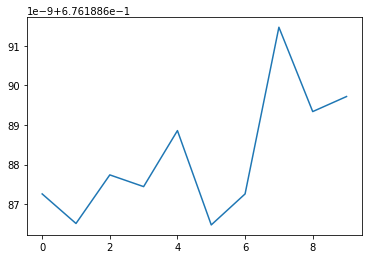

In [95]:
# plot metrics
plt.plot(history.history['acc'])
plt.show()

In [96]:
score = model.evaluate([products_test, users_test, X_test], y_test, verbose=1)
print('Test accuracy:', score[1])

6652/6652 [==============================] - 0s 71us/step
Test accuracy: 0.6761876126405207


In [45]:
T=100
Yt_hat = []
for _ in range(T):
    Yt_hat += [model.predict(X_remain,verbose=0)]

In [62]:
# 100 arrays with one output of each observation for X_test
probs = np.array(Yt_hat)

In [64]:
np.shape(probs[:,1].reshape(-1))

(100,)

In [47]:
predictive_mean = np.mean(Yt_hat, axis=0)

In [48]:
predictive_variance = np.var(Yt_hat, axis = 0)

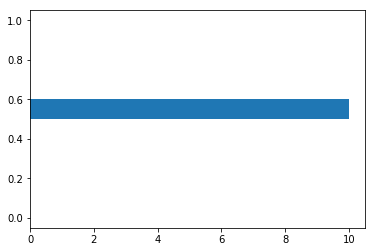

In [74]:
#Stacked bar histogram of output probabilities
plt.figure()
x1=probs[:,1].reshape(-1)
x2 = probs[:,20].reshape(-1)
x3 = probs[:,10].reshape(-1)
plt.hist(x1,normed=True)
plt.show()

In [55]:
Yt_hat[1].reshape(-1)

array([0.50011355, 0.50011355, 0.5001136 , ..., 0.50011355, 0.50011355,
       0.50011355], dtype=float32)